| [![View in Neuro-inspired AI Toolkit Documentation](../_static/toolkit_32px.png)](https://ibm.github.io/neuroaikit/Examples/MNIST.html) |  [![View source on GitHub](../_static/github_32px.png)](https://github.com/IBM/neuroaikit/blob/main/Website/Examples/MNIST.ipynb) |
| - | - |
| View in Neuro-inspired AI Toolkit Documentation | View source on GitHub |

# Image recognition (MNIST)

This tutorial shows how to:

1. Transform static images from MNIST dataset into a temporal stream of spikes (rate coding).
1. Build a conventional LSTM network and a spiking network.
1. Train and evaluate the accuracy and the speed of both models.

## Prepare the input data

Import common and TensorFlow-specific modules:

In [1]:
import neuroaikit as ai
import neuroaikit.tf as aitf

and other modules:

In [2]:
import time
import tensorflow as tf

Load MNIST dataset:

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

This is a static dataset comprising 60000 training images of size 28x28:

In [4]:
train_x.shape

(60000, 28, 28)

Let's use the `transform_rate` function to convert the grayscale pixel values into spike rates over `Ns` time steps:

In [5]:
Ns = 20
max_rate_spikes = 6

In [6]:
# This may take several seconds to execute:
train_x = ai.utils.transform_rate(train_x.reshape(train_x.shape[0], -1) / 255.0, Ns, max_rate_spikes)
test_x = ai.utils.transform_rate(test_x.reshape(test_x.shape[0], -1) / 255.0, Ns, max_rate_spikes)
train_y = tf.keras.utils.to_categorical(train_y) # convert the labels to one-hot representation
test_y = tf.keras.utils.to_categorical(test_y)

This is now a temporal dataset comprising 60000 images of 28x28=784, coded over `Ns` timesteps:

In [7]:
train_x.shape

(60000, 20, 784)

Let's visualize the spikes for a few inputs starting from input line 180:

In [8]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Input index')

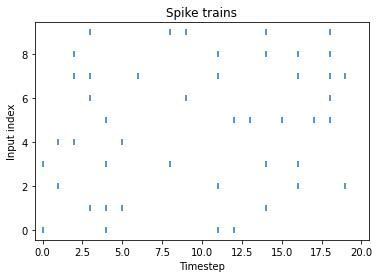

In [9]:
plt.scatter(*np.where(train_x[0,:,180:190]), marker='|')
plt.title('Spike trains')
plt.xlabel('Timestep')
plt.xlim([-0.5,20.5])
plt.ylabel('Input index')

The spiking rate corresponds to the grayscale value of the pixels, so the brighter the pixel, the higher the number of spikes. Instead of spike trains, we can also plot 2D images for each timestep:

(-0.5, 139.5, 27.5, -0.5)

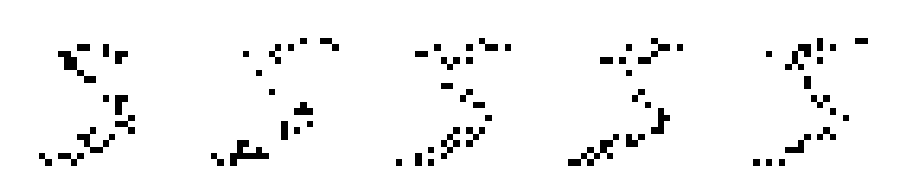

In [10]:
steps = 5 #number of timesteps to plot
plt.matshow(np.hstack(train_x[0,0:steps,:].reshape([steps,28,28])), cmap='binary')
plt.axis('off')

## Build the model

Let's process the inputs using standard LSTMs and also SNNs, with two hidden layers with 250 units each:

In [11]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.InputLayer(input_shape=[None, 28*28]))
lstm_model.add(tf.keras.layers.LSTM(250, return_sequences=True))
lstm_model.add(tf.keras.layers.LSTM(250, return_sequences=True))
lstm_model.add(tf.keras.layers.LSTM(10, return_sequences=True))
lstm_model.add(tf.keras.layers.GlobalAveragePooling1D())  # calculate averaged spiking rate

Using SNUs instead of LSTMs involves changing the type of the layer, optionally setting custom configuration (here `decay` and `g` function), that can be shortened using `config` dictionary:

In [21]:
# Full syntax:
#  model.add(aitf.layers.SNU(250, decay=0.9, g=aitf.activations.leaky_rel, return_sequences=True))
# Shortened syntax with config dictionary:
#  model.add(aitf.layers.SNU(250, **config, return_sequences=True))
config = {'decay': 0.9, 'g': aitf.activations.leaky_rel}

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 28*28]))
model.add(aitf.layers.SNU(250, **config, return_sequences=True))
model.add(aitf.layers.SNU(250, **config, return_sequences=True))
model.add(aitf.layers.SNU(10, **config, return_sequences=True))
model.add(tf.keras.layers.GlobalAveragePooling1D())  # calculate averaged spiking rate

## Train

We train LSTM and SNN for a few epochs only, to quickly run this code also on CPU, but consider running for more epochs to get better accuracy:

In [12]:
epochs = 3

In [13]:
# This will take ~20 minutes on CPU
time_start = time.time()
lstm_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5), loss='mse', metrics=['accuracy'])
lstm_model.fit(train_x, train_y, epochs=epochs, batch_size=15)
loss, acc = lstm_model.evaluate(test_x, test_y)
print("LSTM Loss {}, Accuracy {}".format(loss, acc))
print('Finished. Total time: {0:.1f} [s]'.format(time.time() - time_start))

Epoch 1/3
4000/4000 [==============================] - 331s 82ms/step - loss: 0.0259 - accuracy: 0.8713
Epoch 2/3
4000/4000 [==============================] - 375s 94ms/step - loss: 0.0124 - accuracy: 0.9297
Epoch 3/3
313/313 [==============================] - 26s 79ms/step - loss: 0.0098 - accuracy: 0.9435
LSTM Loss 0.00975897628813982, Accuracy 0.9434999823570251
Finished. Total time: 1106.3 [s]


In [14]:
# This will take ~5 minutes on CPU
time_start = time.time()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5), loss='mse', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=epochs, batch_size=15)
loss, acc = model.evaluate(test_x, test_y)
print("SNN Loss {}, Accuracy {}".format(loss, acc))
print('Finished. Total time: {0:.1f} [s]'.format(time.time() - time_start))

Epoch 1/3
4000/4000 [==============================] - 83s 20ms/step - loss: 0.0249 - accuracy: 0.8771
Epoch 2/3
4000/4000 [==============================] - 86s 21ms/step - loss: 0.0150 - accuracy: 0.9290
Epoch 3/3
313/313 [==============================] - 4s 13ms/step - loss: 0.0112 - accuracy: 0.9484 0s - loss: 0.0111 - ac
SNN Loss 0.011233299039304256, Accuracy 0.9484000205993652
Finished. Total time: 262.2 [s]


Comparing LSTM vs. SNN model:

* SNN is faster to train and execute by ~4x
* SNN achieves higher accuracy